*   This is to support part V.B.ii in our paper
*   We factor sentiment element into Tweets and then visualize the relationship between Amazon stock price and Tweets



In [ ]:
%matplotlib inline 

import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 6

In [ ]:
#Use dataframe that we exported from coding file "V_A_Tweet_Sentiment_Analysis" and stock price data from Kaggle
Amazon = pd.read_csv('Amazon.csv')
company_value = pd.read_csv('CompanyValues.csv')
company_value.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AAPL,2020-05-29,317.94,38399530,319.25,321.15,316.47
1,AAPL,2020-05-28,318.25,33449100,316.77,323.44,315.63
2,AAPL,2020-05-27,318.11,28236270,316.14,318.71,313.09
3,AAPL,2020-05-26,316.73,31380450,323.50,324.24,316.50
4,AAPL,2020-05-22,318.89,20450750,315.77,319.23,315.35


In [ ]:
#Add column of daily returns into the stock price table
company_value['returns'] = company_value.sort_values('day_date').groupby(['ticker_symbol']).close_value.pct_change()
Amazon_value = company_value[company_value['ticker_symbol']=='AMZN'].sort_values('day_date')
Amazon_value.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,returns
5601,AMZN,2010-06-01,123.24,3650661,124.97,126.572,123.0200,NaN
5600,AMZN,2010-06-02,126.31,4747192,124.02,126.430,121.6500,0.024911
5599,AMZN,2010-06-03,128.76,5272208,126.25,129.150,124.8500,0.019397
5598,AMZN,2010-06-04,122.77,5466912,126.33,128.200,122.1800,-0.046521
5597,AMZN,2010-06-07,122.01,6558899,125.84,126.606,121.6744,-0.006190


In [ ]:
#Merge Tweets content and stock price dataframe
Amazon_tweet_vs_value =  pd.merge(Amazon, Amazon_value, left_on=['post_date'], right_on = ['day_date'], how= "inner")
Amazon_tweet_vs_value['post_date'] = Amazon_tweet_vs_value['post_date'].apply(lambda date: pd.to_datetime(date))
Amazon_tweet_vs_value.head()

,Unnamed: 0,Unnamed: 0.1,tweet_id,ticker_symbol_x,writer,post_date,body,comment_num,retweet_num,like_num,...,sentiment_scores,score,ticker_symbol_y,day_date,close_value,volume,open_value,high_value,low_value,returns
0,0,1,550803612197457920,AMZN,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.01,0.0
1,1,4,550803610825928706,AMZN,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.01,0.0
2,2,45,550780769497808896,AMZN,SharePlanner,2015-01-01,2014 Was A Great Year of Trading In The Splash...,1,0,1,...,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",Positive,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.01,0.0
3,3,58,550773410742403072,AMZN,SentiQuant,2015-01-01,#TOPTICKERTWEETS $IMRS $AAPL $BABA $EBAY $AMZN...,0,0,0,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.01,0.0
4,4,96,550743209971036161,AMZN,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $BABA $EBAY $IMRS $AMZN...,0,0,1,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.01,0.0


In [ ]:
#Allocate the numeric score into n_score attribute for each sentiment status: Positive = 1; Neutral = 0.5; Negative = -1
n_score = []
for i in range(len(Amazon_tweet_vs_value['score'])):
    if Amazon_tweet_vs_value['score'][i] == 'Positive':
        n_score.append(1)
    elif Amazon_tweet_vs_value['score'][i] == 'Neutral':
        n_score.append(0.5)
    elif Amazon_tweet_vs_value['score'][i] == 'Negative':
        n_score.append(-1)
Amazon_tweet_vs_value['n_score'] = n_score
Amazon_tweet_vs_value.head(100)

#Calculate the total score of each Tweet
total_score = []
for i in range(len(Amazon_tweet_vs_value['total_engangement'])):
    total_score.append(Amazon_tweet_vs_value['total_engangement'][i]*Amazon_tweet_vs_value['n_score'][i])

Amazon_tweet_vs_value['total_score'] = total_score
Amazon_tweet_vs_value.head()

,Unnamed: 0,Unnamed: 0.1,tweet_id,ticker_symbol_x,writer,post_date,body,comment_num,retweet_num,like_num,...,ticker_symbol_y,day_date,close_value,volume,open_value,high_value,low_value,returns,n_score,total_score
0,0,1,550803612197457920,AMZN,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,...,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.01,0.0,0.5,0.5
1,1,4,550803610825928706,AMZN,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,...,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.01,0.0,0.5,0.5
2,2,45,550780769497808896,AMZN,SharePlanner,2015-01-01,2014 Was A Great Year of Trading In The Splash...,1,0,1,...,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.01,0.0,1.0,2.0
3,3,58,550773410742403072,AMZN,SentiQuant,2015-01-01,#TOPTICKERTWEETS $IMRS $AAPL $BABA $EBAY $AMZN...,0,0,0,...,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.01,0.0,0.5,0.0
4,4,96,550743209971036161,AMZN,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $BABA $EBAY $IMRS $AMZN...,0,0,1,...,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.01,0.0,0.5,0.5


In [ ]:
#Extract data that we want to visualize
Amazon_visual = Amazon_tweet_vs_value[['post_date','score','total_score','returns', 'close_value']]
Amazon_visual.head()

,post_date,score,total_score,returns,close_value
0,2015-01-01,Neutral,0.5,0.0,310.35
1,2015-01-01,Neutral,0.5,0.0,310.35
2,2015-01-01,Positive,2.0,0.0,310.35
3,2015-01-01,Neutral,0.0,0.0,310.35
4,2015-01-01,Neutral,0.5,0.0,310.35


In [ ]:
#Group the data by post_date
Amazon_visual_group = Amazon_visual.groupby(['post_date'])['close_value','returns','total_score'].mean()
Amazon_visual_group

<ipython-input-7-c5e2ec232a72>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Amazon_visual_group = Amazon_visual.groupby(['post_date'])['close_value','returns','total_score'].mean()


,close_value,returns,total_score
post_date,,,
2015-01-01,310.35,0.000000,0.503817
2015-01-02,308.52,-0.005897,2.373563
2015-01-03,308.52,0.000000,0.440299
2015-01-04,308.52,0.000000,0.158824
2015-01-05,302.19,-0.020517,0.391459
...,...,...,...
2019-12-27,1869.80,0.000551,3.392857
2019-12-28,1869.80,0.000000,5.585561
2019-12-29,1869.80,0.000000,4.516447


In [ ]:
Amazon_posneg = Amazon_visual.groupby(['post_date'])['close_value','returns','total_score'].mean('total_score')
Amazon_posneg

<ipython-input-8-092e2b2d1f82>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Amazon_posneg = Amazon_visual.groupby(['post_date'])['close_value','returns','total_score'].mean('total_score')


,close_value,returns,total_score
post_date,,,
2015-01-01,310.35,0.000000,0.503817
2015-01-02,308.52,-0.005897,2.373563
2015-01-03,308.52,0.000000,0.440299
2015-01-04,308.52,0.000000,0.158824
2015-01-05,302.19,-0.020517,0.391459
...,...,...,...
2019-12-27,1869.80,0.000551,3.392857
2019-12-28,1869.80,0.000000,5.585561
2019-12-29,1869.80,0.000000,4.516447


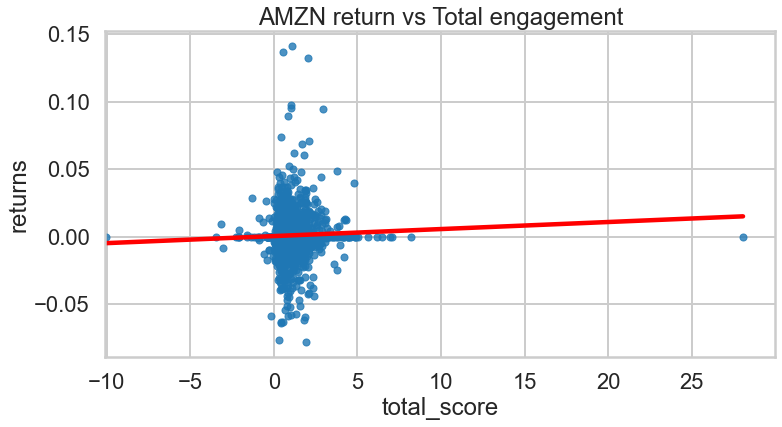

In [ ]:
#Visualize relationship between stock return and total score
sns.regplot(x='total_score', y="returns", data=Amazon_visual_group, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("AMZN return vs Total engagement")
plt.show()

In [ ]:
#Filter data for positive tweets only
Amazon_pos = Amazon_visual[Amazon_visual['score'] == 'Positive']
Amazon_pos.head()

,post_date,score,total_score,returns,close_value
2,2015-01-01,Positive,2.0,0.0,310.35
5,2015-01-01,Positive,2.0,0.0,310.35
8,2015-01-01,Positive,3.0,0.0,310.35
9,2015-01-01,Positive,2.0,0.0,310.35
10,2015-01-01,Positive,2.0,0.0,310.35


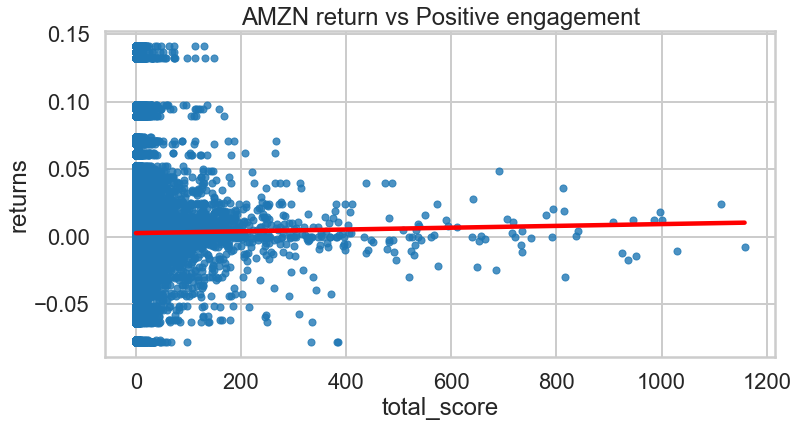

In [ ]:
#Visualize relationship between stock return and total score for positive tweets only
sns.regplot(x='total_score', y="returns", data=Amazon_pos, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("AMZN return vs Positive engagement")
plt.show()

In [ ]:
#Filter data for negative tweets only
Amazon_neg = Amazon_visual[Amazon_visual['score'] == 'Negative']
Amazon_neg.head()

,post_date,score,total_score,returns,close_value
18,2015-01-01,Negative,-0.0,0.0,310.35
25,2015-01-01,Negative,-0.0,0.0,310.35
27,2015-01-01,Negative,-217.0,0.0,310.35
28,2015-01-01,Negative,-4.0,0.0,310.35
29,2015-01-01,Negative,-0.0,0.0,310.35


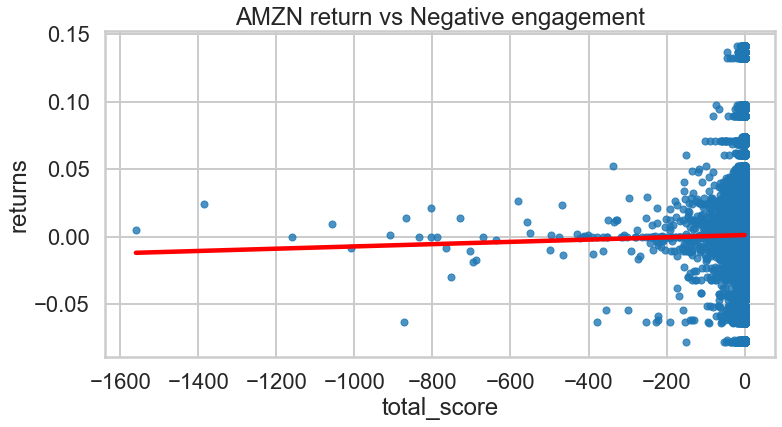

In [ ]:
#Visualize relationship between stock return and total score for negative tweets only
sns.regplot(x='total_score', y="returns", data=Amazon_neg, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("AMZN return vs Negative engagement")
plt.show()

In [ ]:
Total_pos_tweets = Amazon_pos.groupby('post_date').mean('total_score')
Total_pos_tweets.head()

,total_score,returns,close_value
post_date,,,
2015-01-01,11.571429,0.000000,310.35
2015-01-02,5.381579,-0.005897,308.52
2015-01-03,0.750000,0.000000,308.52
2015-01-04,1.000000,0.000000,308.52
2015-01-05,0.716667,-0.020517,302.19


In [ ]:
Total_neg_tweets = Amazon_neg.groupby('post_date').mean('total_score')
Total_neg_tweets.head()

,total_score,returns,close_value
post_date,,,
2015-01-01,-7.049180,0.000000,310.35
2015-01-02,-0.617647,-0.005897,308.52
2015-01-03,-0.875000,0.000000,308.52
2015-01-04,-2.500000,0.000000,308.52
2015-01-05,-0.689655,-0.020517,302.19


<ipython-input-16-0621b9c736c0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Amazon_returns['returns'] = Amazon_returns['returns'].apply(lambda returns: returns*50)


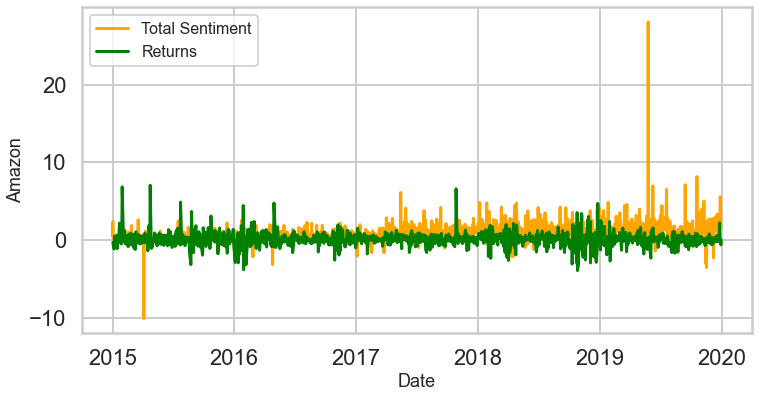

In [ ]:
#Visualize stock return and total score of sentiment per day.
Amazon_returns = Amazon_visual_group[Amazon_visual_group['returns'] != 0]
Amazon_returns['returns'] = Amazon_returns['returns'].apply(lambda returns: returns*50)
plt.xlabel("Date" , fontsize = 18)
plt.ylabel("Amazon", fontsize = 18)

sns.lineplot(
data = Amazon_posneg,
        x = 'post_date',
        y = 'total_score', 
        color = 'orange'
    )
sns.lineplot(
data = Amazon_returns,
        x = 'post_date',
        y = 'returns', 
        color = 'green'
    )
#"Positive Sentiment", "Negative Sentiment",
plt.legend(labels=["Total Sentiment", "Returns"],fontsize = 16)